### 构建神经网络
#### 数据获取

In [18]:
# 抓取网页内容用的包
import json
import requests

# PyTorch用的包
import torch
import torch.nn as nn
import torch.optim as optim

# 自然语言处理相关的包
import re
import jieba  # 结巴分词器
from collections import Counter  # 搜集器，可以让统计词频更简单

# 绘图、计算用的包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### 数据处理

In [19]:
# 数据来源文件
good_file = 'E:/ai_learning_resource/mood_classifier/good.txt'
bad_file = 'E:/ai_learning_resource/mood_classifier/bad.txt'

# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)
    return sentence

# 扫描所有文本，分词并建立词典，分出正向还是负向的评论，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(good_file, bad_file, is_filter=True):
    all_words = []
    pos_sentences = []
    neg_sentences = []
    with open(good_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                # 过滤标点符号
                line = filter_punc(line)
            # 分词
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行，{2} 个词。'.format(good_file, idx+1, len(all_words)))
    count = len(all_words)
    with open(bad_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
                words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行，{2} 个词。'.format(bad_file, idx+1, len(all_words)-count))
    
    # 建立词典，diction的每一项为{w:[id, 单词出现频次]}
    diction = {}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('字典大小：{}'.format(len(diction)))
    return pos_sentences, neg_sentences, diction

# 调用Prepare_data，完成数据处理工作
pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, True)
st = sorted([(v[1], w) for w, v in diction.items()])

E:/ai_learning_resource/mood_classifier/good.txt 包含 854 行，19936 个词。
E:/ai_learning_resource/mood_classifier/bad.txt 包含 306 行，4695 个词。
字典大小：3875


In [20]:
# 根据单词返回单词的编码
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return value

# 根据编码获得对应的单词
def index2word(index, diction):
    for w, v in diction.items():
        if v[0] == index:
            return w
    return None

#### 文本数据向量化

In [21]:
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence, dictionary):
    vector = np.zeros(len(dictionary))
    for l in sentence:
        vector[l] += 1
    return(1.0 * vector / len(sentence))

# 遍历所有句子，将每一个词映射成编码
dataset = [] #数据集
labels = [] #标签
sentences = [] #原始句子，调试用
# 处理正向评论
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(0) #正标签为0
    sentences.append(sentence)

# 处理负向评论
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1) #负标签为1
    sentences.append(sentence)

#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(dataset))

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

#### 划分数据集

In [22]:
#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

#### 建立神经网络

In [23]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(dim=1),
)

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

#### 训练模型

In [24]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []

#循环10个Epoch
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = torch.tensor(np.array([y]), dtype = torch.long)
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

第0轮，训练损失：0.60, 校验损失：0.66, 校验准确率: 0.69
第1轮，训练损失：0.40, 校验损失：0.24, 校验准确率: 0.92
第2轮，训练损失：0.27, 校验损失：0.22, 校验准确率: 0.90
第3轮，训练损失：0.20, 校验损失：0.24, 校验准确率: 0.90
第4轮，训练损失：0.16, 校验损失：0.27, 校验准确率: 0.91
第5轮，训练损失：0.13, 校验损失：0.29, 校验准确率: 0.91
第6轮，训练损失：0.11, 校验损失：0.31, 校验准确率: 0.90
第7轮，训练损失：0.10, 校验损失：0.31, 校验准确率: 0.90
第8轮，训练损失：0.09, 校验损失：0.31, 校验准确率: 0.90
第9轮，训练损失：0.08, 校验损失：0.32, 校验准确率: 0.90


#### 运行结果

0.9473684210526315

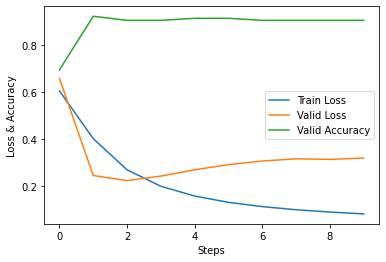

In [25]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = torch.tensor(data, dtype = torch.float).view(1,-1), torch.tensor(np.array([target]), dtype = torch.long)
    output = model(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

### 剖析神经网络
#### 查看每一层的模式

In [26]:
# 将神经网络的架构打印出来，方便后面的访问
model.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Linear(in_features=3875, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)>

Text(0, 0.5, 'Weights')

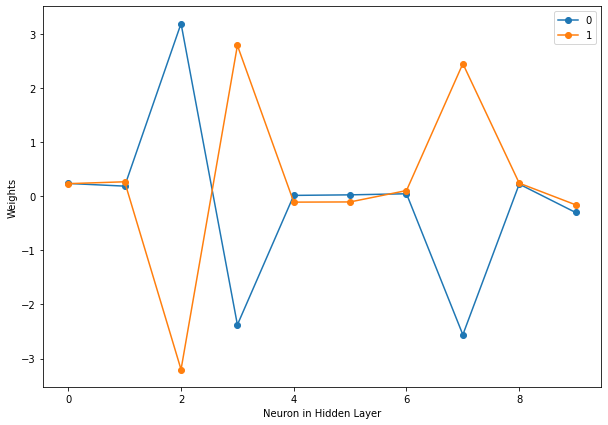

In [27]:
# 绘制出第二个全链接层的权重大小
# model[2]即提取第2层，网络一共4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经原链接，第3层为logsoftmax
plt.figure(figsize = (10, 7))
for i in range(model[2].weight.size()[0]):
    #if i == 1:
        weights = model[2].weight[i].data.numpy()
        plt.plot(weights, 'o-', label = i)
plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')

Text(0, 0.5, 'Weights')

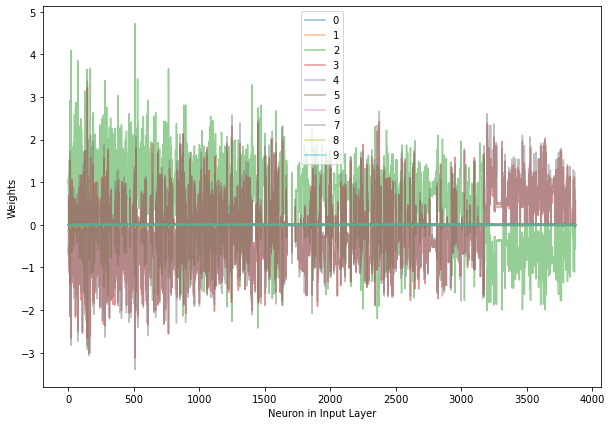

In [28]:
# 将第一层神经元的权重都打印出来，一条曲线表示一个隐含层神经元。横坐标为输入层神经元编号，纵坐标为权重值大小
plt.figure(figsize = (10, 7))
for i in range(model[0].weight.size()[0]):
    #if i == 1:
        weights = model[0].weight[i].data.numpy()
        plt.plot(weights, alpha = 0.5, label = i)
plt.legend()
plt.xlabel('Neuron in Input Layer')
plt.ylabel('Weights')

In [29]:
# 将第二层的各个神经元与输入层的链接权重，挑出来最大的权重和最小的权重，并考察每一个权重所对应的单词是什么，把单词打印出来
# model[0]是取出第一层的神经元

for i in range(len(model[0].weight)):
    print('\n')
    print('第{}个神经元'.format(i))
    print('max:')
    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
    for i in range(1, 20):
        word = index2word(st[-i][1],diction)
        print(word)
    print('min:')
    for i in range(20):
        word = index2word(st[i][1],diction)
        print(word)



第0个神经元
max:
偶尔
顶多
上次
纸张
无误
沟通交流
墨迹
推广
原版
教训
回饋
简图
无忧
生意兴隆
废
文字
看吧
接着
凭空
min:
这
公司
参加
大家
贵
有
一点点
用
不错
活动
读书
借阅
因为
的
被
出去
不
买来
是
上架


第1个神经元
max:
是
因为
了
有
贵
就是
特地
活动
反馈
不
任何
一
被
一点点
时间
新书
买来
这
本书
min:
不错
打
解决问题
那些
没收
差
没有
服务
人
不到
虚
尴尬
什么
不想
越来越
客服
发票
破
玩意
找


第2个神经元
max:
快
学习
不错
很快
优惠
希望
需要
讲解
Linux
值得
比较
活动
很棒
好
经典
严实
工作
挺
基础
min:
这样
不好
卖
说好
失望
盗版
直接
请
没收
拆过
号
几天
降价
不想
吗
子书
八十多
就算
plus
块钱


第3个神经元
max:
这样
降价
不好
盗版
卖
说好
失望
吗
拆过
不要
不想
没收
请
几天
错误
只能
问
号
plus
min:
快
喜欢
学习
希望
很快
方便
优惠
不错
讲解
很棒
终于
收到
自学
理解
活动
棒
经典
需要
评论
觉得


第4个神经元
max:
济世
背面
毕业
进
照常
这强
销售额
点多
东西
們
难道
配送
提高
出名
按理
寄书
来讲
说真的
拆过
min:
對
精通
出乎
书
几十本
久
来看
图文并茂
好心人
全本
相似
下来
感谢
1Linux
唯恐
难得
漫长
穿越
容易
推荐


第5个神经元
max:
顺畅
笼统
经验
印刷
动不动
文档
人用
吧
想法
活动室
殿堂
失去
二维码
观察
过滤
于是
这人
小结
例子
min:
视频教程
尴尬
没有
玩不起
调货
原本
逛逛
并
充分
物超所值
只
果断
文件系统
看过
企业
炒鸡
读者群
连
图可
BILIBILI


第6个神经元
max:
事业部
封膜
一分钱
日期
送货员
一步步
大约
让你能
安排
哼
官方
就是说
几次
合适
肺腑
趁着
可是
宝贝
弄坏了
min:
是
大家
因为
贵
价格
活动
买来
任何
这
被
参加
不
反馈
有
借阅
用
第一
特地
新书
一点点


第7个神经元
max:
这样
降价
盗版
卖
不好
问
吗
说好
太差
垃圾
不想
不要
失望


#### 寻找判断错误的原因

In [30]:
# 收集到在测试集中判断错误的句子
wrong_sentences = []
targets = []
j = 0
sent_indices = []
for data, target in zip(test_data, test_label):
    predictions = model(torch.tensor(data, dtype = torch.float).view(1,-1))
    pred = torch.max(predictions.data, 1)[1]
    target = torch.tensor(np.array([target]), dtype = torch.long).view_as(pred)
    rights = pred.eq(target)
    indices = np.where(rights.numpy() == 0)[0]
    for i in indices:
        wrong_sentences.append(data)
        targets.append(target[i])
        sent_indices.append(test_size + j + i)
    j += len(target)

In [31]:
# 逐个查看出错的句子是什么
idx = 1
print(sent_indices)
print(sentences[sent_indices[idx]])
print(targets[idx].numpy())
lst = list(np.where(wrong_sentences[idx]>0)[0])
mm = list(map(lambda x:index2word(x, diction), lst))
print(mm)

[130, 135, 136, 173, 208, 213]
['太脏', '太旧', '了', '别人', '用过']
1
['了', '别人', '用过', '太脏', '太旧']


In [32]:
# 观察第一层的权重与输入向量的内积结果，也就是对隐含层神经元的输入，其中最大数值对应的项就是被激活的神经元
# 负值最小的神经元就是被抑制的神经元
model[0].weight.data.numpy().dot(wrong_sentences[idx].reshape(-1, 1))

array([[-0.01033949],
       [ 0.01842942],
       [ 0.51556687],
       [ 0.02710389],
       [ 0.00154573],
       [-0.00493155],
       [-0.01330565],
       [-0.07543613],
       [-0.014416  ],
       [-0.00459894]])

In [33]:
# 显示输入句子的非零项，即对应单词不为空的项，看它们到隐含层指定神经元的权重是多少
model[0].weight[0].data.numpy()[np.where(wrong_sentences[idx]>0)[0]]

array([-0.05127325, -0.00461036, -0.00699436,  0.01209478, -0.00091428],
      dtype=float32)